Import IDC images from local drive

In [1]:
#Import relevant packages
import kaggle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from glob import glob
from skimage.io import imread
from PIL import Image
import fnmatch
import cv2

In [2]:
#Import data from local drive
files = os.listdir('C:/Users/benja/Dropbox/Ben Code/Springboard not GIT linked/IDC_image_data/breast-histopathology-images')
print(len(files))
base_path = 'C:/Users/benja/Dropbox/Ben Code/Springboard not GIT linked/IDC_image_data/breast-histopathology-images/IDC_regular_ps50_idx5/'
folder = os.listdir(base_path)

280


We have 280 folders, the releventdata all seems to be held in the IDC_regular_ps50_idx5 folder, so I've made that the base_path for easy reference. Next lets pull patient ID into a workable object and determine how many images we're working with

In [3]:
#Create patient_ID object and count total number of patches(portions of image slides)
total_images = 0
for n in range(len(folder)):
    patient_ID = folder[n]
    for c in [0, 1]:
        patient_path = base_path + patient_ID 
        class_path = patient_path + "/" + str(c) + "/"
        subfiles = os.listdir(class_path)
        total_images += len(subfiles)
               
print(total_images)

277524


Wow, almost 280,000 patches to work through! Next, let's build a dataframe to work with that includes if IDC is present in that patch (0-absent, 1-present).

In [4]:
#Build a dataframe
df = pd.DataFrame(index = np.arange(0,total_images), columns = ['patient_ID','path', 'IDC'])

k = 0
for n in range(len(folder)):
    patient_ID = folder[n]
    patient_path = base_path + patient_ID 
    for c in [0,1]:
        class_path = patient_path + "/" + str(c) + "/"
        subfiles = os.listdir(class_path)
        for m in range(len(subfiles)):
            image_path = subfiles[m]
            df.iloc[k]["path"] = class_path + image_path
            df.iloc[k]["IDC"] = c
            df.iloc[k]["patient_ID"] = patient_ID
            k += 1  
            
df.head()

,patient_ID,path,IDC
0,10253,C:/Users/benja/Dropbox/Ben Code/Springboard no...,0
1,10253,C:/Users/benja/Dropbox/Ben Code/Springboard no...,0
2,10253,C:/Users/benja/Dropbox/Ben Code/Springboard no...,0
3,10253,C:/Users/benja/Dropbox/Ben Code/Springboard no...,0
4,10253,C:/Users/benja/Dropbox/Ben Code/Springboard no...,0


Perfect! Now let's take a look at some of our data distributions - how many patches do we have per patient? How many images have IDC visible? What fraction of those images is covered by a tumor?

C:\Users\benja\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


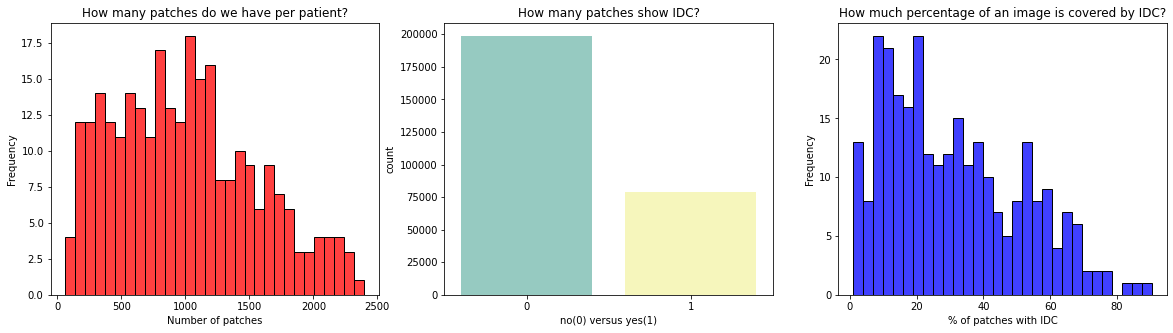

In [5]:
cancer_perc = df.groupby("patient_ID").IDC.value_counts()/ df.groupby("patient_ID").IDC.size()
cancer_perc = cancer_perc.unstack()

fig, ax = plt.subplots(1,3,figsize=(20,5))
sns.histplot(df.groupby("patient_ID").size(), ax=ax[0], color="red", kde=False, bins=30)
ax[0].set_xlabel("Number of patches")
ax[0].set_ylabel("Frequency");
ax[0].set_title("How many patches do we have per patient?");
sns.countplot(df.IDC, palette="Set3", ax=ax[1]);
ax[1].set_xlabel("no(0) versus yes(1)")
ax[1].set_title("How many patches show IDC?");
sns.histplot(cancer_perc.loc[:, 1]*100, ax=ax[2], color="blue", kde=False, bins=30)
ax[2].set_title("How much percentage of an image is covered by IDC?")
ax[2].set_ylabel("Frequency")
ax[2].set_xlabel("% of patches with IDC");

OK, so pretty good range of patch counts per patient, looks like some patches are over 80% IDC tumors, and the majority of patches don't contain IDC tumors. Let's look at what these patches actually look like!

In [6]:
#First we'll randomly select 25 patches of both IDC positive and negative images:
df.IDC = df.IDC.astype(np.int)

pos_selection = np.random.choice(df[df.IDC==1].index.values, size=25, replace=False)
neg_selection = np.random.choice(df[df.IDC==0].index.values, size=25, replace=False)

Next we'll build some subplots to show the randomly selected slides

Positive

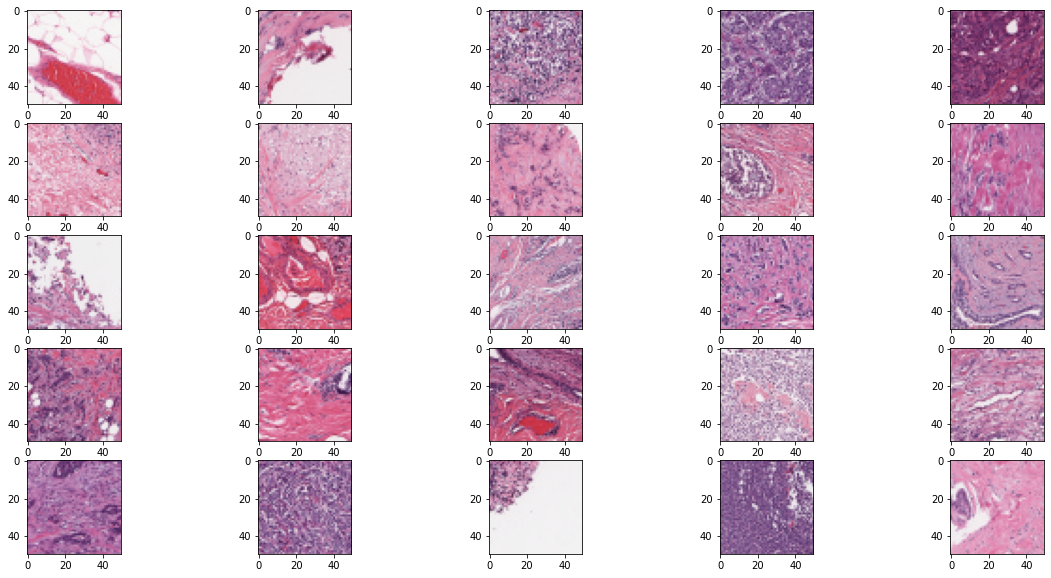

In [7]:
#Next we'll build some subplots to show those randomly selected slides

fig, ax = plt.subplots(5,5,figsize=(20,10))

for n in range(5):
    for m in range(5):
        idx = pos_selection[m + 5*n]
        image = imread(df.loc[idx, "path"])
        ax[n,m].imshow(image)
        ax[n,m].grid(False)

Negative

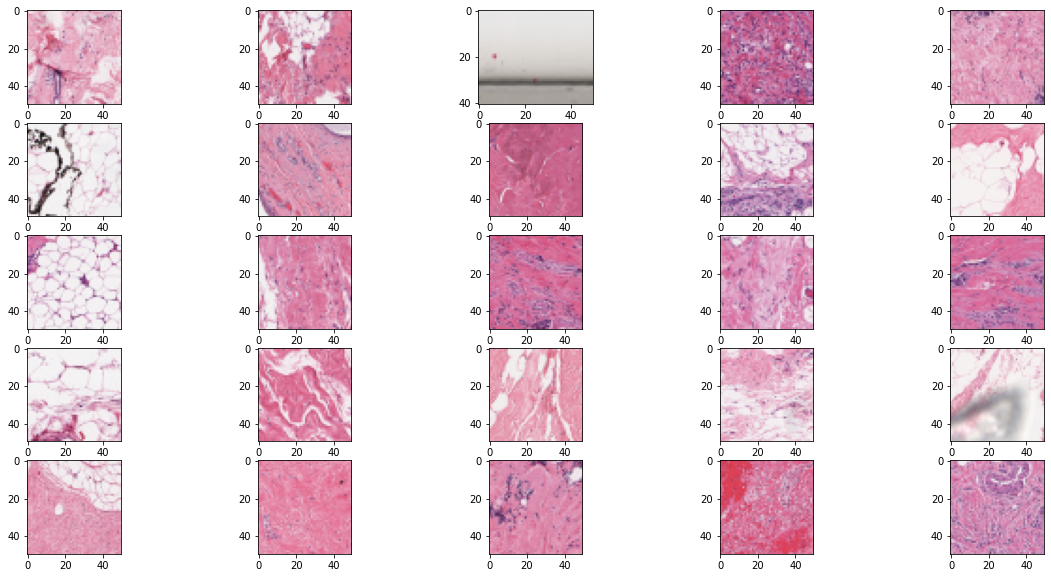

In [8]:
fig, ax = plt.subplots(5,5,figsize=(20,10))

for n in range(5):
    for m in range(5):
        idx = neg_selection[m + 5*n]
        image = imread(df.loc[idx, "path"])
        ax[n,m].imshow(image)
        ax[n,m].grid(False)

Next lets adjust the pixel values of each image to be between 0 and 1, this will help for standardizing images before we start training models.

In [ ]:
#first load all images and resize them to standard sizes

resized_image =[]
images = glob('C:/Users/benja/Dropbox/Ben Code/Springboard not GIT linked/IDC_image_data/breast-histopathology-images/IDC_regular_ps50_idx5/**/*.png', recursive=True)
for img in images:
        full_size_image = cv2.imread(img)
        resized_image.append(cv2.resize(full_size_image, (50,50), interpolation=cv2.INTER_CUBIC))

In [ ]:
#Next we're going to convert the pixel values to be between 0 and 1 for faster processing later on - most pixel values are between 0 and 255 so we'll just divide them by 255
scaled_image = np.array(resized_image) #create an array of pixel values for each image from resized_image
scaled_image = scaled_image/255 #scale the pixel values to be between 0 and 1 for faster analysis
print(scaled_image[0]) #check a random image for any values over 1
